In [1]:
import Ipynb_importer
import warp
import homography
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.spatial import Delaunay
import imregistration
import sift
import imp


importing Jupyter notebook from warp.ipynb
importing Jupyter notebook from homography.ipynb
importing Jupyter notebook from imregistration.ipynb
importing Jupyter notebook from sift.ipynb


In [2]:
import homography
imp.reload(homography)

importing Jupyter notebook from homography.ipynb


<module 'homography' from 'homography.ipynb'>

# <font color = black>3.2 图像扭曲</font>

im = np.array(Image.open('im1.jpg').convert('L'))
#im = np.array(Image.open('im1.jpg'))
H = np.array([[1.4,0.05,-100],[0.05,1.5,-100],[0,0,1]])

im2 = homography.ndimage.affine_transform(im,H[:2,:2],(H[0,2],H[1,2]))

plt.figure()
plt.gray()
plt.imshow(im)
plt.axis('off')
plt.show()
plt.imshow(im2)
plt.axis('off')
plt.show()

## <font color = black>3.2.1图像中的图像</font>

#仿射扭曲im1到im2
im1 = np.array(Image.open('beatles.jpg').convert('L'))
im2 = np.array(Image.open('billboard_for_rent.jpg').convert('L'))
#im2 = np.array(Image.open('beatles.jpg').convert('L'))
print(im1.shape)
print(im2.shape)
plt.imshow(im1)
plt.gray()
plt.show()
plt.imshow(im2)
plt.show()

#选定一些目标点
#tp = np.array([[264,538,540,264],[40,36,605,605],[1,1,1,1]])
#tp = np.array([[675,826,826,677],[55,52,281,277],[1,1,1,1]])

tp = np.array([[130,210,210,130],[20,20,170,170],[1,1,1,1]])
print('tp:\n',tp)

im3 = warp.image_in_image(im1,im2,tp)

plt.figure()
plt.gray()
plt.imshow(im3)
#plt.axis('equal')
#plt.axis('off')
plt.show()

#选定im1角上的一些点
m,n = im1.shape[:2]
fp = np.array([[0,m,m,0],[0,0,n,n],[1,1,1,1]])

#第一个三角形
tp2 = tp[:,:3]
fp2 = fp[:,:3]

#计算仿射变换H
H = homography.Haffine_from_points(tp2,fp2)
im1_t = ndimage.affine_transform(im1,H[:2,:2],(H[0,2],H[1,2]),im2.shape[:2])

#三角形的alpha图像
alpha = warp.alpha_for_triangle(tp2,im2.shape[0],im2.shape[1])
im3 = (1-alpha)*im2 + alpha*im1_t

#第二个三角形
tp2 = tp[:,[0,2,3]]
fp2 = fp[:,[0,2,3]]

#计算H
H = homography.Haffine_from_points(tp2,fp2)
im1_t = ndimage.affine_transform(im1,H[:2,:2],(H[0,2],H[1,2]),im2.shape[:2])

#三角形的alpha图像
alpha = warp.alpha_for_triangle(tp2,im2.shape[0],im2.shape[1])
im4 = (1-alpha)*im3 + alpha*im1_t

plt.figure()
plt.gray()
plt.imshow(im4)
plt.show()


## <font color = black>3.2.2分段仿射扭曲</font>

x,y = np.array(np.random.standard_normal((2,100)))
tri = Delaunay(np.c_[x,y]).simplices

plt.figure()
for t in tri:
    t_ext = [t[0],t[1],t[2],t[0]]
    plt.plot(x[t_ext],y[t_ext],'r')

plt.plot(x,y,'*')
plt.show()

#打开图像，并将其扭曲
fromim = np.array(Image.open('sunset_tree.jpg'))
x,y = np.meshgrid(range(5),range(6))
#print(x)
#print(y)
x = (fromim.shape[1]/4)*x.flatten()
y = (fromim.shape[0]/5)*y.flatten()

#三角剖分
tri = warp.triangulate_points(x,y)

#打开图像和目标点
im = np.array(Image.open('turningtorso1.jpg'))
tp = np.loadtxt('turningtorso1_points.txt',dtype=int)    #destination points

#将点转换成齐次坐标
fp = np.vstack((y,x,np.ones((1,len(tp)))))
tp = np.vstack((tp[:,1],tp[:,0],np.ones((1,len(tp)))))
#print(tp,'\n\n')
tp = tp.astype(int)
#print('int\n',tp,'\n\n')
#扭曲三角形

im = warp.pw_affine(fromim,im,fp,tp,tri)


plt.figure()
plt.imshow(im)
warp.plot_mesh(tp[1],tp[0],tri)
plt.show()

## <font color = black>3.2.3 图像配准</font>

xmlFileName = 'jkfaces.xml'
points = imregistration.read_points_from_xml(xmlFileName)

#print(points)
#print(list(points.values()))
#print(list(points.values())[0])


imregistration.rigid_alignment(points,'jkfaces/')

## <font color = black>3.3 创建全景图</font>|

<font color = red>有一些问题导致匹配不准，在找问题</font>

In [4]:
featname = ['Univ'+str(i+1)+'.sift' for i in range(5)]
imname = ['Univ'+str(i+1)+'.jpg' for i in range(5)]

l = {}
d = {}

for i in range(5):
    sift.process_image(imname[i],featname[i])
    l[i],d[i] = sift.read_features_from_file(featname[i])
    
matches = {}

for i in range(4):
    matches[i] = sift.match(d[i+1],d[i])
    

tmp.pgm
processed tmp.pgm to Univ1.sift
tmp.pgm
processed tmp.pgm to Univ2.sift
tmp.pgm
processed tmp.pgm to Univ3.sift
tmp.pgm
processed tmp.pgm to Univ4.sift
tmp.pgm
processed tmp.pgm to Univ5.sift


In [5]:
matches = {}

for i in range(4):
    matches[i] = sift.match(d[i+1],d[i])

In [118]:
#将匹配转换成齐次坐标点
def convert_points(j):
    ndx = matches[j].nonzero()[0]
    #print(ndx)
    fp = homography.make_homog(l[j+1][ndx,:2].T)
    ndx2 = [int(matches[j][i]) for i in ndx]
    #print(ndx2)
    tp = homography.make_homog(l[j][ndx2,:2].T)
    
    return fp,tp

In [113]:
import homography
imp.reload(homography)

importing Jupyter notebook from homography.ipynb


<module 'homography' from 'homography.ipynb'>

In [114]:
#估计单应性矩阵
model = homography.RansacModel()
    
fp,tp = convert_points(1)
#tp = fp
#print(fp)
#print(tp)
#H_12 = homography.H_from_ransac(fp,tp,model,maxiter=1000,match_theshold=10)[0]    #im1到im2的单应性矩阵
H_12 = homography.H_from_ransac(fp,tp,model,maxiter=3000)[0]    #im1到im2的单应性矩阵
    


In [ ]:
fp,tp = convert_points(0)
H_01 = homography.H_from_ransac(fp,tp,model)[0]    #im0到im1的单应性矩阵
    
tp,fp = convert_points(2)
H_32 = homography.H_from_ransac(fp,tp,model)[0]    #im3到im2的单应性矩阵
    
tp,fp = convert_points(3)
H_43 = homography.H_from_ransac(fp,tp,model)[0]    #im4到im3的单应性矩阵

In [115]:
import warp
imp.reload(warp)

importing Jupyter notebook from warp.ipynb


<module 'warp' from 'warp.ipynb'>

warp - left


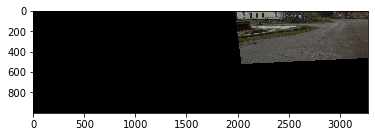

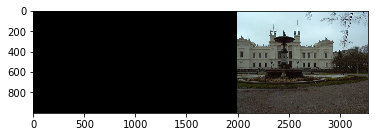

In [116]:
delta = 2000    #用于填充和平移

im1 = np.array(Image.open(imname[1]))
im2 = np.array(Image.open(imname[2]))
im1,im2,alpha = warp.panorama(H_12,im1,im2,delta,delta)

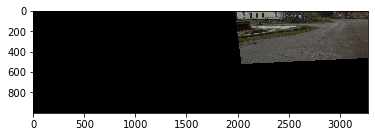

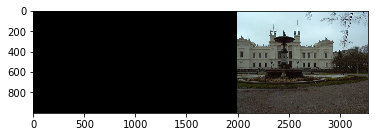

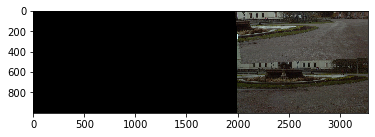

In [117]:
im_plot(im1)
im_plot(im2)
for col in range(3):
    im1[:,:,col] = im1[:,:,col]*alpha + im2[:,:,col]*(1-alpha)
    
im_plot(im1)

In [89]:
print(1-alpha)

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]]


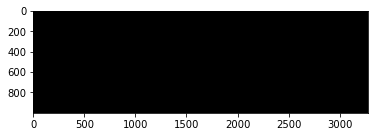

In [90]:
im_plot(im_12)

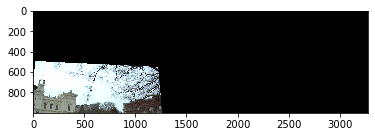

In [84]:
im_plot(im_12)

In [65]:
delta = 2000    #用于填充和平移

im1 = np.array(Image.open(imname[1]))
im2 = np.array(Image.open(imname[2]))
im_12 = warp.panorama(H_12,im1,im2,delta,delta)


im1 = np.array(Image.open(imname[0]))
im_02 = warp.panorama(np.dot(H_12,H_01),im1,im_12,delta,delta)

im1 = np.array(Image.open(imname[3]))
im_32 = warp.panorama(H_32,im1,im_02,delta,delta)

im1 = np.array(Image.open(imname[4]))
im_42 = warp.panorama(np.dot(H_32,H_43),im1,im_32,delta,2*delta)


True
warp - right
True
warp - right
True
warp - left
True
warp - right


In [66]:
def im_plot(im):
    plt.figure()
    plt.imshow(im.astype('uint8'))
    plt.show()

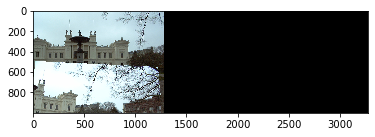

In [68]:
im_plot()

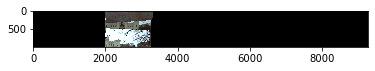

In [67]:
im_plot(im_42)